<a href="https://colab.research.google.com/github/rkudulis/Deep-Learning-Notebooks/blob/main/fashion-category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import re
from tqdm import tqdm
import imageio

In [3]:
! cp /content/drive/MyDrive/fashion-dataset.zip /content/ -v


'/content/drive/MyDrive/fashion-dataset.zip' -> '/content/fashion-dataset.zip'


In [ ]:
!unzip fashion-dataset.zip

In [9]:
IMAGES_PATH = "/content/fashion-dataset/images"
STYLES_PATH = "/content/fashion-dataset/styles"
STYLES_FILE_PATH = "/content/fashion-dataset/styles.csv"
IMAGES_FILE_PATH = "/content/fashion-dataset/images.csv"

In [22]:
styles_df = pd.read_csv(STYLES_FILE_PATH, index_col=False, error_bad_lines=False)
print(styles_df.shape)
styles_df.head()

(44424, 10)


b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [23]:
styles_df.masterCategory = styles_df.masterCategory.astype('category').cat.codes

In [24]:
images = os.listdir("/content/fashion-dataset/images")
len(images)

44441

In [25]:
images_list = [re.findall(r"\d+", x)[0] for x in images]
images_list = [int(x) for x in images_list]
len(images_list)

44441

In [30]:
styles_df = styles_df[styles_df.id.isin(images_list)]
styles_df.shape

(44419, 10)

In [31]:
train_df, valid_df = torch.utils.data.random_split(styles_df, [30_000, 14_419], generator=torch.Generator().manual_seed(42))

In [40]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transforms=None):
        self.dataset = dataset
        self.indices = indices
        self.transforms = transforms

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        id = row.id
        label = row.masterCategory
        path = f"/content/images/{id}.jpg"
        image = Image.open(path)
        if self.transforms:
            image = self.transforms(image)
        return image, label


In [41]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(1),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.Normalize(mean=[.8], std=[.5])
])

In [42]:
train_dataset = TrainDataset(styles_df, train_df.indices, transforms=transform)
valid_dataset = TrainDataset(styles_df, valid_df, transforms=transform)

torch.Size([1, 128, 128])
2


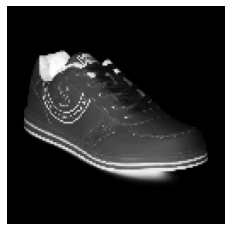

In [43]:
img, label = train_dataset[155]
print(img.shape)
print(label)
plt.imshow(img.reshape(128,128), cmap='binary')
plt.axis('off');

In [44]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 64, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 64, shuffle=True) 

In [45]:
input_size = 128*128
hidden_size = [256, 64]
output_size = 7

model = nn.Sequential(
    nn.Linear(input_size, hidden_size[0]),
    nn.ReLU(),
    nn.Linear(hidden_size[0], hidden_size[1]),
    nn.ReLU(),
    nn.Linear(hidden_size[1], output_size),
    nn.LogSoftmax(dim=1)
)
model

Sequential(
  (0): Linear(in_features=16384, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=7, bias=True)
  (5): LogSoftmax(dim=1)
)

In [46]:
criterion =nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [47]:
if torch.cuda.is_available():
    model = model.cuda()
    optimizer = optimizer

In [ ]:
epochs = 1

for e in range(epochs):
    for images, labels in tqdm(train_dataloader, position=0, leave=True):
        images = images.view(-1, 128*128)
        labels =labels.long()
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

  3%|▎         | 13/469 [01:24<50:11,  6.61s/it]

In [ ]:
img.flatten().shape

torch.Size([21760])